# Post-processing of simulation results

This notebook visualizes the following simulation results:

- global Sherwood number
- local Sherwood number
- wake concentration

Compared are:

- different mesh resolutions
- for the hybrid approach: the influence of the velocity and mesh motion boundary conditions
- hybrid approach and SGS model

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

cases = ["CB{:1d}".format(i) for i in range(1, 5)]
print("Case names : ", cases)

data_path_sgs = "../data/32_cells/"
data_path_hybrid = "../openfoam/run/"
output_path = "../output/"

Case names :  ['CB1', 'CB2', 'CB3', 'CB4']


## Loading the data
### Global Sherwood numbers

In [2]:
sh_glob_hybrid = {}
names = ["time", "Sh_eff", "area"]

for case in cases:
    for sc in ["s1", "s2", "s3"]:
        path = data_path_hybrid + case + "_ref_1/globalSh_" + sc + ".csv"
        sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)

for sc in ["s1", "s2", "s3"]:
    path = data_path_hybrid + "CB4_ref_0/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    path = data_path_hybrid + "CB4_ref_2_parallel/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    path = data_path_hybrid + "CB4_ref_1_slip/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    path = data_path_hybrid + "CB4_ref_1_frozen/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)

In [3]:
sh_glob_sgs = {}
folders = ["{:s}_{:d}".format(case, sc) for case in cases for sc in [100, 1000, 10000]]
names = ["col{:1d}".format(col) for col in range(10)]
names[0] = "time"
names[2] = "Sh"

for folder in folders:
    path = data_path_sgs + "GlobalSh/{:s}/targetmarker_profile.dat".format(folder)
    sh_glob_sgs[folder] = pd.read_csv(path, sep=" ", header=None, names=names, usecols=["time", "Sh"])

### Local Sherwood numbers

In [27]:
sh_local_hybrid = {}
times = ["0.5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5", "5.5", "6", "6.5", "7", "7.5", "8", "8.5", "9", "9.5", "10"]
names = ["x", "y", "z", "area", "sh"]

for case in cases:
    for time in times:
        for sc in ["s1", "s2", "s3"]:
            path = data_path_hybrid + case + "_ref_1/{:s}/localSh_{:s}.csv".format(time, sc)
            data = pd.read_csv(path, header=0, names=names)
            data["theta"] = np.arccos(data.y.values / np.sqrt(np.power(data.x.values, 2) + np.power(data.y.values, 2)))
            sh_local_hybrid[path] = data.copy()

# mesh dependency and influence of slip boundary condition only for case CB4
for time in times[:4]:
    for sc in ["s1", "s2", "s3"]:
        # refinemnt levels 0 and 2 for mesh dependency study
        path = data_path_hybrid + "CB4_ref_0/{:s}/localSh_{:s}.csv".format(time, sc)
        data = pd.read_csv(path, header=0, names=names)
        data["theta"] = np.arccos(data.y.values / np.sqrt(np.power(data.x.values, 2) + np.power(data.y.values, 2)))
        sh_local_hybrid[path] = data.copy()
        path = data_path_hybrid + "CB4_ref_2_parallel/{:s}/localSh_{:s}.csv".format(time, sc)
        data = pd.read_csv(path, header=0, names=names)
        data["theta"] = np.arccos(data.y.values / np.sqrt(np.power(data.x.values, 2) + np.power(data.y.values, 2)))
        sh_local_hybrid[path] = data.copy()
        # local data for mesh motion with slip and frozen shape
        path = data_path_hybrid + "CB4_ref_1_slip/{:s}/localSh_{:s}.csv".format(time, sc)
        data = pd.read_csv(path, header=0, names=names)
        data["theta"] = np.arccos(data.y.values / np.sqrt(np.power(data.x.values, 2) + np.power(data.y.values, 2)))
        sh_local_hybrid[path] = data.copy()
        path = data_path_hybrid + "CB4_ref_1_frozen/{:s}/localSh_{:s}.csv".format(time, sc)
        data = pd.read_csv(path, header=0, names=names)
        data["theta"] = np.arccos(data.y.values / np.sqrt(np.power(data.x.values, 2) + np.power(data.y.values, 2)))
        sh_local_hybrid[path] = data.copy()

In [28]:
sh_local_sgs = {}
num_timestep = 1.0e-4
rows = [int(float(t)/num_timestep) for t in times]
names = np.arange(1, 180, 2)

for case in cases:
    for sc_num in ["100", "1000", "10000"]:
        path = data_path_sgs + "LocalSh/{:s}_{:s}/localSh_x".format(case, sc_num)
        data = pd.read_csv(path, sep=" ", header=None, skiprows=lambda x: x not in rows, usecols=range(90), names=names)
        sh_local_sgs["{:s}_{:s}".format(case, sc_num)] = data.copy()

### Wake concentration

In [6]:
wake_hybrid = {}
names = ["y", "c1", "c2", "c3"]

for case in cases:
    for time in times:
        path = data_path_hybrid + "{:s}_ref_1/postProcessing/singleGraph/{:s}/line_s1_s2_s3.xy".format(case, time)
        data = pd.read_csv(path, sep="\t", header=None, names=names)
        data["sd"] = data.y - data.y.values[0]
        wake_hybrid["{:s}_t{:s}".format(case, time)] = data.copy()
        
# mesh dependency and influence of slip boundary condition only for case CB4
for time in times[:4]:
    path = data_path_hybrid + "CB4_ref_2_parallel/postProcessing/singleGraph/{:s}/line_s1_s2_s3.xy".format(time)
    data = pd.read_csv(path, sep="\t", header=None, names=names)
    data["sd"] = data.y - data.y.values[0]
    wake_hybrid["CB4_ref2_t{:s}".format(time)] = data.copy()
    path = data_path_hybrid + "CB4_ref_1_slip/postProcessing/singleGraph/{:s}/line_s1_s2_s3.xy".format(time)
    data = pd.read_csv(path, sep="\t", header=None, names=names)
    data["sd"] = data.y - data.y.values[0]
    wake_hybrid["CB4_slip_t{:s}".format(time)] = data.copy()
    path = data_path_hybrid + "CB4_ref_1_frozen/postProcessing/singleGraph/{:s}/line_s1_s2_s3.xy".format(time)
    data = pd.read_csv(path, sep="\t", header=None, names=names)
    data["sd"] = data.y - data.y.values[0]
    wake_hybrid["CB4_frozen_t{:s}".format(time)] = data.copy()

## Mesh dependency hybrid approach

In [7]:
def sh_lochiel(re, sc):
    return 2.0/np.sqrt(np.pi) * np.sqrt(1.0 - 2.96/np.sqrt(re)) * np.sqrt(re*sc)

In [8]:
viscosity = np.array([2.18064e-2, 1.01347e-2, 6.11814e-3, 4.19665e-3])
rise_vel = []
for case in cases:
    log_path = output_path + case + "/log_file.pkl"
    log = pd.read_pickle(log_path)
    rise_vel.append(log[log.t > 7].ub_x.mean())
rise_vel = np.array(rise_vel)
reynolds = rise_vel/viscosity
for case, re in zip(cases, reynolds):
    print("Reynolds number for case {:s}: {:5.2f}".format(case, re))

Reynolds number for case CB1: 71.99
Reynolds number for case CB2: 243.03
Reynolds number for case CB3: 429.73
Reynolds number for case CB4: 569.31


Sc=100
hybrid: 276
Lochiel & Calderbank: 252 (-8.69%)
--------------------
Sc=1000
hybrid: 868
Lochiel & Calderbank: 797 (-8.24%)
--------------------
Sc=10000
hybrid: 2742
Lochiel & Calderbank: 2520 (-8.09%)
--------------------


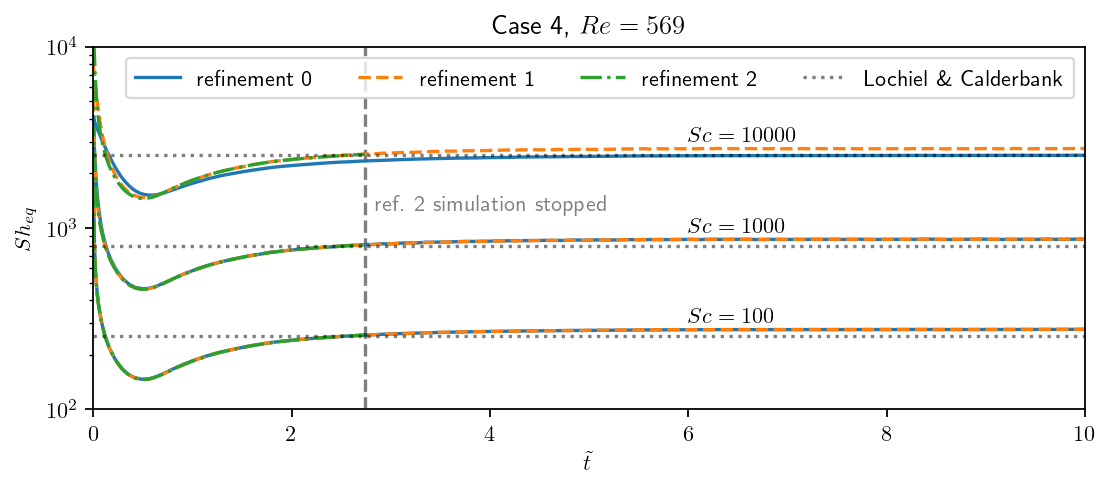

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
area_eq = np.pi * 3.0/360.0

schmidt = [100, 1000, 10000]
for i, sc in enumerate(["s1", "s2", "s3"]):
    ref_0 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_0/globalSh_" + sc + ".csv"]
    ref_1 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_1/globalSh_" + sc + ".csv"]
    ref_2 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_2_parallel/globalSh_" + sc + ".csv"]
    sh_eq_0 = ref_0.Sh_eff*ref_0.area/area_eq
    sh_eq_1 = ref_1.Sh_eff*ref_1.area/area_eq
    sh_eq_2 = ref_2.Sh_eff*ref_2.area/area_eq
    sh_ref = sh_lochiel(reynolds[-1], schmidt[i])
    print("Sc={:3.0f}".format(schmidt[i]))
    print("hybrid: {:3.0f}".format(np.round(sh_eq_1.values[-1])))
    print("Lochiel & Calderbank: {:3.0f} ({:3.2f}%)".format(np.round(sh_ref), (sh_ref - sh_eq_1.values[-1]) / sh_eq_1.values[-1] * 100))
    print("-"*20)
    if i < 1:
        ax.plot(ref_0.time, sh_eq_0, color="C0", ls="-", label=r"refinement 0".format(schmidt[i]))
        ax.plot(ref_1.time, sh_eq_1, color="C1", ls="--", label=r"refinement 1".format(schmidt[i]))
        ax.plot(ref_2.time, sh_eq_2, color="C2", ls="-.", label=r"refinement 2".format(schmidt[i]))
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5, label="Lochiel \& Calderbank")
        ax.axvline(ref_2.time.values[-1], ls="--", color="k", alpha=0.5)
        ax.text(ref_2.time.values[-1]+0.1, 1250, "ref. 2 simulation stopped", alpha=0.5)
    else:
        ax.plot(ref_0.time, sh_eq_0, color="C0", ls="-")
        ax.plot(ref_1.time, sh_eq_1, color="C1", ls="--")
        ax.plot(ref_2.time, sh_eq_2, color="C2", ls="-.")
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5)
        
    ax.text(6.0, sh_ref*1.2, r"$Sc={:4.0f}$".format(schmidt[i]))
    
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$Sh_{eq}$")
ax.set_yscale("log")
ax.set_xlim(0.0, 10.0)
ax.set_ylim(100, 10000)
ax.legend(ncol=4)
ax.set_title(r"Case 4, $Re={:2.0f}$".format(np.round(reynolds[-1], 0)))
plt.savefig(output_path + "sh_glob_mesh_dep_hybrid.pdf", bbox_inches="tight")

In [65]:
def compute_sh_sector_average(data, n_sectors=90):
    sector_width = np.pi / n_sectors
    sector_ubounds = np.arange(sector_width, np.pi + 0.1 * sector_width, sector_width)
    theta = data.theta.values
    sort_ind = theta.argsort()
    sh = data.sh.values[sort_ind]
    area = data.area.values[sort_ind]
    x = data.x.values[sort_ind]
    rad = np.sqrt(np.square(data.x.values) + np.square(data.y.values))
    rad = rad[sort_ind]
    theta = theta[sort_ind]
    current_sector = 0
    area_sum = 0.0
    sh_sum = 0.0
    theta_sum = 0.0
    x_sum = 0.0
    rad_sum = 0.0
    sh_sec = np.zeros(n_sectors)
    theta_sec = np.zeros(n_sectors)
    x_sec = np.zeros(n_sectors)
    rad_sec = np.zeros(n_sectors)
    for i, t in enumerate(theta):
        if t <= sector_ubounds[current_sector]:
            sh_sum += sh[i] * area[i]
            theta_sum += theta[i] * area[i]
            x_sum += x[i] * area[i]
            rad_sum += rad[i] * area[i]
            area_sum += area[i] 
        else:
            sh_sec[current_sector] = sh_sum / area_sum
            theta_sec[current_sector] = theta_sum / area_sum
            x_sec[current_sector] = x_sum / area_sum
            rad_sec[current_sector] = rad_sum / area_sum
            area_sum = area[i]
            sh_sum = sh[i] * area[i]
            theta_sum = theta[i] * area[i]
            x_sum = x[i] * area[i]
            rad_sum = rad[i] * area[i]
            current_sector += 1
    sh_sec[current_sector] = sh_sum / area_sum
    theta_sec[current_sector] = theta_sum / area_sum
    x_sec[current_sector] = x_sum / area_sum
    rad_sec[current_sector] = rad_sum / area_sum
    return rad_sec, x_sec, theta_sec, sh_sec

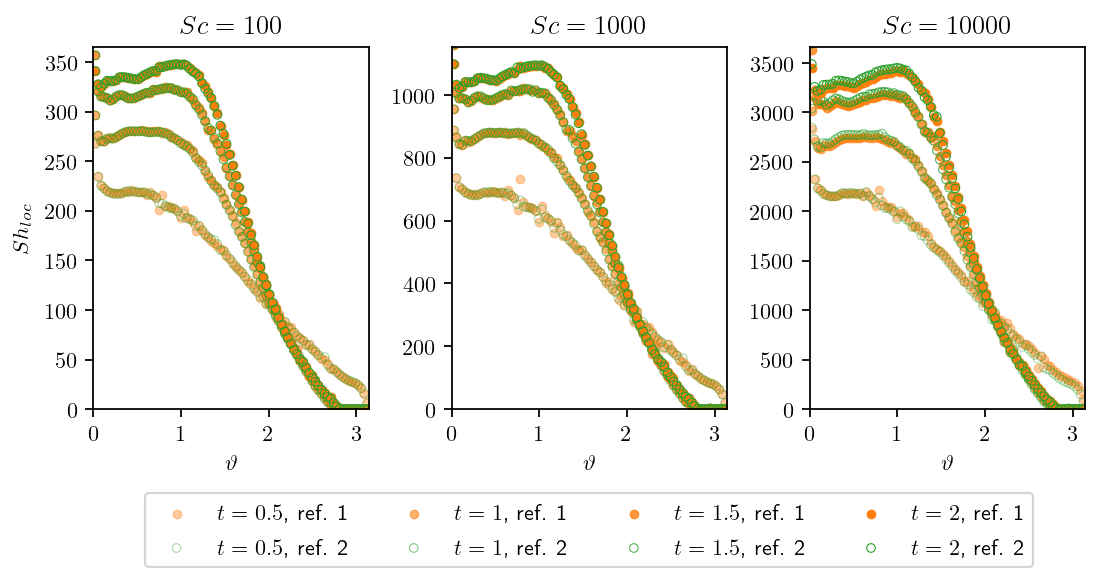

In [66]:
fig, axarr = plt.subplots(1, 3, figsize=(8, 3))

alpha = [0.4, 0.6, 0.8, 1.0]
ms = 15
lw = 0.5

for i, sc in enumerate(["s1", "s2", "s3"]):
    for j, time in enumerate(times[:4]):
        #ref_0 = sh_local_hybrid[data_path_hybrid + "CB4_ref_0/{:s}/localSh_{:s}.csv".format(time, sc)]
        ref_1 = sh_local_hybrid[data_path_hybrid + "CB4_ref_1/{:s}/localSh_{:s}.csv".format(time, sc)]
        ref_2 = sh_local_hybrid[data_path_hybrid + "CB4_ref_2_parallel/{:s}/localSh_{:s}.csv".format(time, sc)]
        _, _, theta_1, sh_1 = compute_sh_sector_average(ref_1)
        _, _, theta_2, sh_2 = compute_sh_sector_average(ref_2)
        if i == 1:
            axarr[i].scatter(theta_1, sh_1, color="C1", marker="o", lw=lw, alpha=alpha[j], s=ms, label=r"$t={:s}$, ref. 1".format(time))
            axarr[i].scatter(theta_2, sh_2, facecolors='none', edgecolors='C2', marker="o", lw=lw, alpha=alpha[j], s=ms, label=r"$t={:s}$, ref. 2".format(time))
        else:
            axarr[i].scatter(theta_1, sh_1, color="C1", marker="o", lw=lw, alpha=alpha[j], s=ms)
            axarr[i].scatter(theta_2, sh_2, facecolors='none', edgecolors='C2', marker="o", lw=lw, alpha=alpha[j], s=ms)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_ylim(0.0, np.max(sh_2)*1.05)
    axarr[i].set_title(r"$Sc={:4.0f}$".format(schmidt[i]))
    axarr[i].set_xlabel(r"$\vartheta$")
    box = axarr[i].get_position()
    axarr[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    
axarr[0].set_ylabel(r"$Sh_{loc}$")
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.subplots_adjust(wspace=0.3)
plt.savefig(output_path + "sh_local_mesh_dep_hybrid.pdf", bbox_inches="tight")

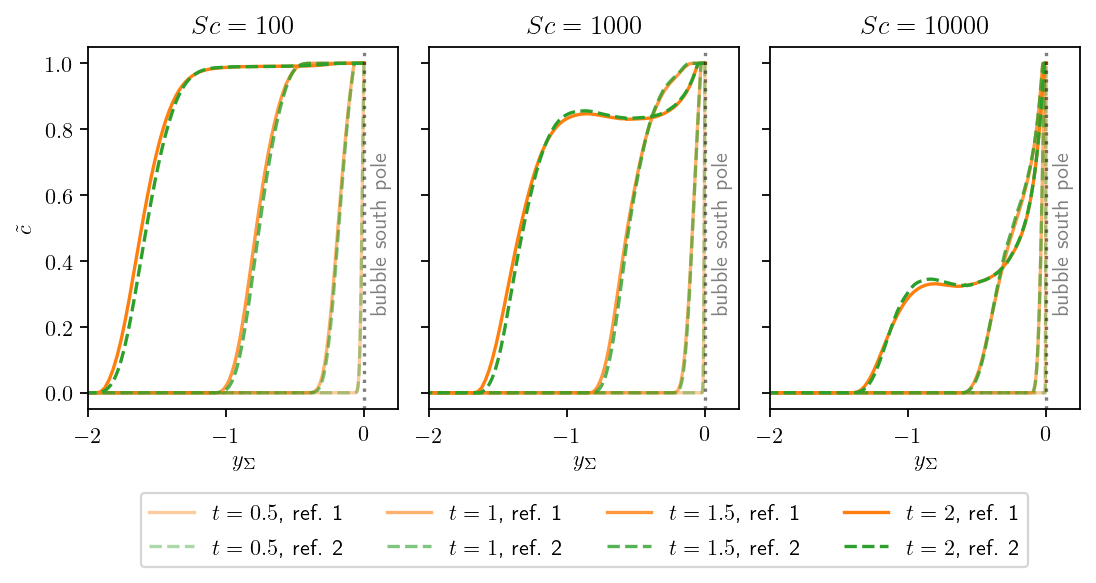

In [12]:
fig, axarr = plt.subplots(1, 3, figsize=(8, 3))

alpha = [0.4, 0.6, 0.8, 1.0]

for i, sc in enumerate(["s1", "s2", "s3"]):
    for j, time in enumerate(times[:4]):
        ref_1 = wake_hybrid["CB4_t{:s}".format(time)]
        ref_2 = wake_hybrid["CB4_ref2_t{:s}".format(time)]
        if i == 1:
            axarr[i].plot(ref_1.sd, ref_1[["c1", "c2", "c3"]].values[:, i], color="C1", ls="-", alpha=alpha[j], label=r"$t={:s}$, ref. 1".format(time))
            axarr[i].plot(ref_2.sd, ref_2[["c1", "c2", "c3"]].values[:, i], color="C2", ls="--", alpha=alpha[j], label=r"$t={:s}$, ref. 2".format(time))
        else:
            axarr[i].plot(ref_1.sd, ref_1[["c1", "c2", "c3"]].values[:, i], color="C1", ls="-", alpha=alpha[j])
            axarr[i].plot(ref_2.sd, ref_2[["c1", "c2", "c3"]].values[:, i], color="C2", ls="--", alpha=alpha[j])
            
    if i > 0:
        axarr[i].set_yticklabels([])
    axarr[i].axvline(0.0, color="k", ls=":", alpha=0.5)
    axarr[i].text(0.05, 0.25, r"bubble south pole", rotation=90, alpha=0.5)
    axarr[i].set_xlabel(r"$y_\Sigma$")
    axarr[i].set_xlim(-2.0, 0.25)
    axarr[i].set_title(r"$Sc={:d}$".format(schmidt[i]))
    box = axarr[i].get_position()
    axarr[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    
axarr[0].set_ylabel(r"$\tilde{c}$")
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.subplots_adjust(wspace=0.1)
plt.savefig(output_path + "wake_mesh_dep_hybrid.pdf", bbox_inches="tight")

## Comparison between hybird appraoch, mesh motion + slip, and static shape + slip

final steady state, Sc=100
hybrid: 276
dyn. mesh, slip: 291 (5.29%)
stat. mesh, slip: 262 (-4.94%)
Lochiel & Calderbank: 252 (-8.69%)
----------------------------------------
maximum dynamic difference, Sc=100
dyn. mesh, slip: -11.43% at t=0.77
stat. mesh, slip: -13.21% at t=0.81
----------------------------------------
final steady state, Sc=1000
hybrid: 868
dyn. mesh, slip: 916 (5.45%)
stat. mesh, slip: 826 (-4.84%)
Lochiel & Calderbank: 797 (-8.24%)
----------------------------------------
maximum dynamic difference, Sc=1000
dyn. mesh, slip: -12.15% at t=0.77
stat. mesh, slip: -13.83% at t=0.79
----------------------------------------
final steady state, Sc=10000
hybrid: 2742
dyn. mesh, slip: 2889 (5.39%)
stat. mesh, slip: 2595 (-5.36%)
Lochiel & Calderbank: 2520 (-8.09%)
----------------------------------------
maximum dynamic difference, Sc=10000
dyn. mesh, slip: -12.36% at t=0.77
stat. mesh, slip: -14.22% at t=0.80
----------------------------------------


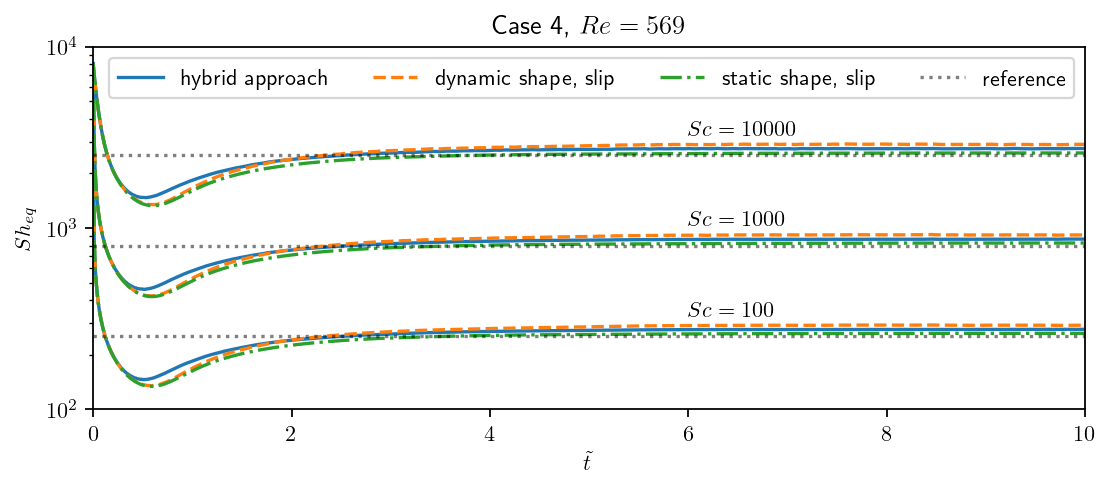

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
area_eq = np.pi * 3.0/360.0

schmidt = [100, 1000, 10000]
for i, sc in enumerate(["s1", "s2", "s3"]):
    hybrid = sh_glob_hybrid[data_path_hybrid + "CB4_ref_1/globalSh_" + sc + ".csv"]
    slip = sh_glob_hybrid[data_path_hybrid + "CB4_ref_1_slip/globalSh_" + sc + ".csv"]
    frozen = sh_glob_hybrid[data_path_hybrid + "CB4_ref_1_frozen/globalSh_" + sc + ".csv"]
    
    sh_eq_hybrid = hybrid.Sh_eff*hybrid.area/area_eq
    sh_eq_slip = slip.Sh_eff*slip.area/area_eq
    sh_eq_frozen = frozen.Sh_eff*frozen.area/area_eq
    sh_ref = sh_lochiel(reynolds[-1], schmidt[i])
    print("final steady state, Sc={:3.0f}".format(schmidt[i]))
    print("hybrid: {:3.0f}".format(np.round(sh_eq_hybrid.values[-1])))
    print("dyn. mesh, slip: {:3.0f} ({:3.2f}%)".format(np.round(sh_eq_slip.values[-1]), (sh_eq_slip.values[-1] - sh_eq_hybrid.values[-1]) / sh_eq_hybrid.values[-1] * 100))
    print("stat. mesh, slip: {:3.0f} ({:3.2f}%)".format(np.round(sh_eq_frozen.values[-1]), (sh_eq_frozen.values[-1] - sh_eq_hybrid.values[-1]) / sh_eq_hybrid.values[-1] * 100))
    print("Lochiel & Calderbank: {:3.0f} ({:3.2f}%)".format(np.round(sh_ref), (sh_ref - sh_eq_hybrid.values[-1]) / sh_eq_hybrid.values[-1] * 100))
    print("-"*40)
    print("maximum dynamic difference, Sc={:3.0f}".format(schmidt[i]))
    diff_slip = np.absolute(sh_eq_slip.values - sh_eq_hybrid.values)/sh_eq_hybrid.values * 100
    max_sign_slip = np.sign((sh_eq_slip.values - sh_eq_hybrid.values)[np.argmax(diff_slip)])
    print("dyn. mesh, slip: {:3.2f}% at t={:1.2f}".format(np.round(np.max(diff_slip), 2)*max_sign_slip, hybrid.time.values[np.argmax(diff_slip)]))
    diff_frozen = np.absolute(sh_eq_frozen.values - sh_eq_hybrid.values)/sh_eq_hybrid.values * 100
    max_sign_frozen = np.sign((sh_eq_frozen.values - sh_eq_hybrid.values)[np.argmax(diff_frozen)])
    print("stat. mesh, slip: {:3.2f}% at t={:1.2f}".format(np.round(np.max(diff_frozen), 2)*max_sign_slip, hybrid.time.values[np.argmax(diff_frozen)]))
    print("-"*40)
    if i < 1:
        ax.plot(hybrid.time, sh_eq_hybrid, color="C0", ls="-", label=r"hybrid approach".format(schmidt[i]))
        ax.plot(slip.time, sh_eq_slip, color="C1", ls="--", label=r"dynamic shape, slip".format(schmidt[i]))
        ax.plot(frozen.time, sh_eq_frozen, color="C2", ls="-.", label=r"static shape, slip".format(schmidt[i]))
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5, label="reference")
    else:
        ax.plot(hybrid.time, sh_eq_hybrid, color="C0", ls="-")
        ax.plot(slip.time, sh_eq_slip, color="C1", ls="--")
        ax.plot(frozen.time, sh_eq_frozen, color="C2", ls="-.")
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5)
        
    ax.text(6.0, sh_ref*1.3, r"$Sc={:4.0f}$".format(schmidt[i]))
    
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$Sh_{eq}$")
ax.set_yscale("log")
ax.set_xlim(0.0, 10.0)
ax.set_ylim(100, 10000)
ax.legend(ncol=4)
ax.set_title(r"Case 4, $Re={:2.0f}$".format(np.round(reynolds[-1], 0)))
plt.savefig(output_path + "sh_glob_slip.pdf", bbox_inches="tight")

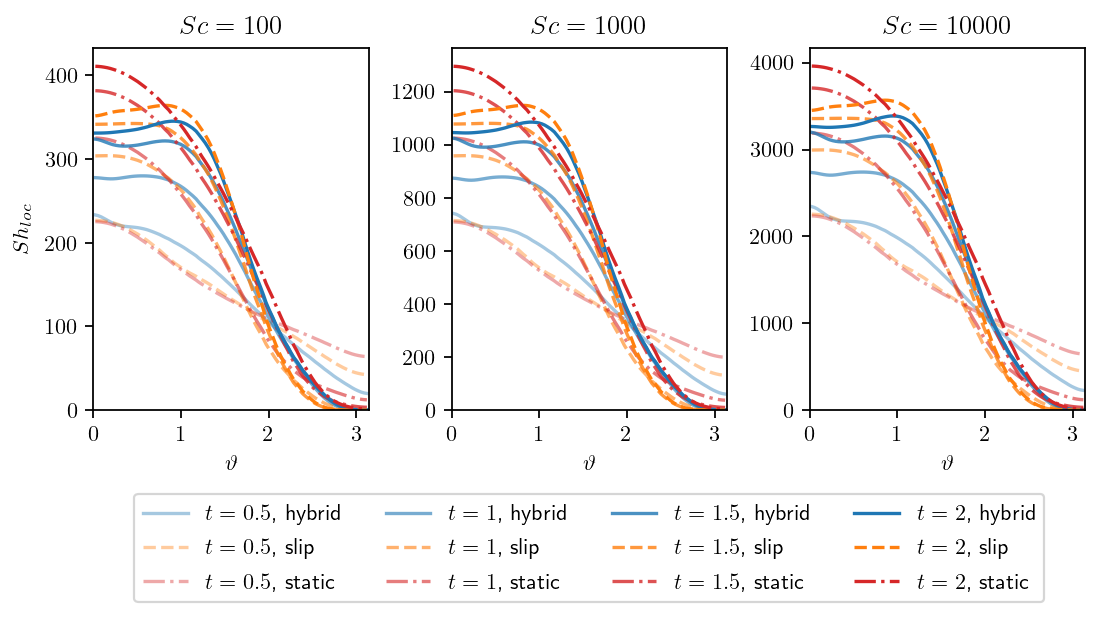

In [67]:
fig, axarr = plt.subplots(1, 3, figsize=(8, 3))

alpha = [0.4, 0.6, 0.8, 1.0]
sigma = 4

for i, sc in enumerate(["s1", "s2", "s3"]):
    for j, time in enumerate(times[:4]):
        hybrid = sh_local_hybrid[data_path_hybrid + "CB4_ref_1/{:s}/localSh_{:s}.csv".format(time, sc)]
        slip = sh_local_hybrid[data_path_hybrid + "CB4_ref_1_slip/{:s}/localSh_{:s}.csv".format(time, sc)]
        frozen = sh_local_hybrid[data_path_hybrid + "CB4_ref_1_frozen/{:s}/localSh_{:s}.csv".format(time, sc)]
        _, _, theta_1, sh_1 = compute_sh_sector_average(hybrid)
        _, _, theta_2, sh_2 = compute_sh_sector_average(slip)
        _, _, theta_3, sh_3 = compute_sh_sector_average(frozen)
        if i == 1:
            axarr[i].plot(theta_1, gaussian_filter1d(sh_1, sigma=sigma), color="C0", ls="-", alpha=alpha[j], label=r"$t={:s}$, hybrid".format(time))
            axarr[i].plot(theta_2, gaussian_filter1d(sh_2, sigma=sigma), color="C1", ls="--", alpha=alpha[j], label=r"$t={:s}$, slip".format(time))
            axarr[i].plot(theta_3, gaussian_filter1d(sh_3, sigma=sigma), color="C3", ls="-.", alpha=alpha[j], label=r"$t={:s}$, static".format(time))
        else:
            axarr[i].plot(theta_1, gaussian_filter1d(sh_1, sigma=sigma), color="C0", ls="-", alpha=alpha[j])
            axarr[i].plot(theta_2, gaussian_filter1d(sh_2, sigma=sigma), color="C1", ls="--", alpha=alpha[j])
            axarr[i].plot(theta_3, gaussian_filter1d(sh_3, sigma=sigma), color="C3", ls="-.", alpha=alpha[j])
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_ylim(0.0, np.max(sh_3)*1.05)
    axarr[i].set_title(r"$Sc={:4.0f}$".format(schmidt[i]))
    axarr[i].set_xlabel(r"$\vartheta$")
    box = axarr[i].get_position()
    axarr[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    
axarr[0].set_ylabel(r"$Sh_{loc}$")
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.subplots_adjust(wspace=0.3)
plt.savefig(output_path + "sh_local_slip.pdf", bbox_inches="tight")

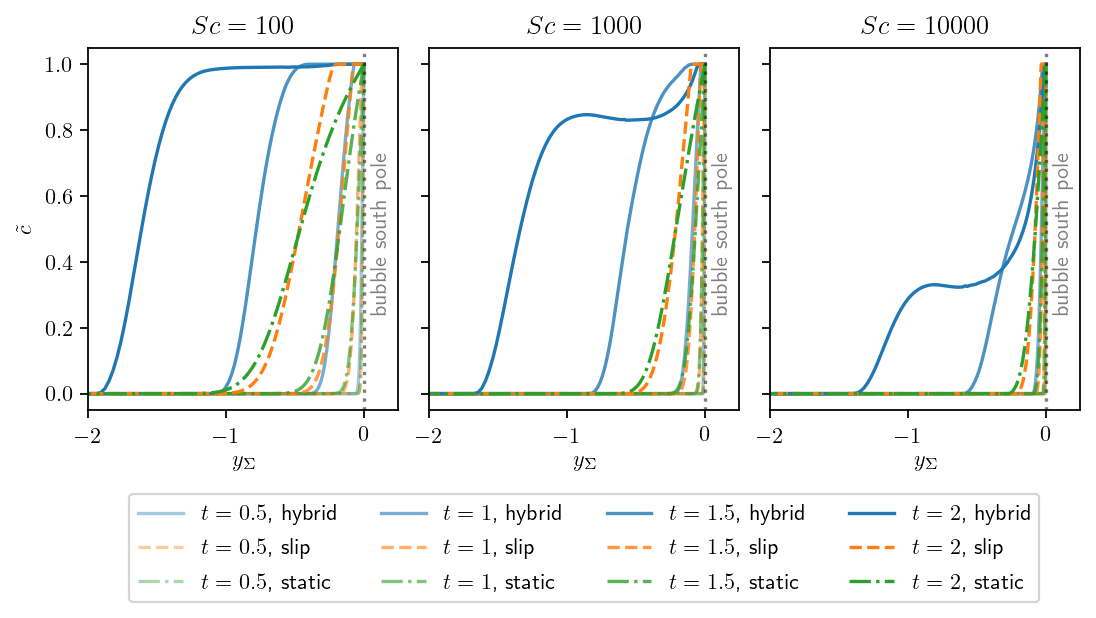

In [15]:
fig, axarr = plt.subplots(1, 3, figsize=(8, 3))

alpha = [0.4, 0.6, 0.8, 1.0]

for i, sc in enumerate(["s1", "s2", "s3"]):
    for j, time in enumerate(times[:4]):
        hybrid = wake_hybrid["CB4_t{:s}".format(time)]
        slip = wake_hybrid["CB4_slip_t{:s}".format(time)]
        frozen = wake_hybrid["CB4_frozen_t{:s}".format(time)]
        if i == 1:
            axarr[i].plot(hybrid.sd, hybrid[["c1", "c2", "c3"]].values[:, i], color="C0", ls="-", alpha=alpha[j], label=r"$t={:s}$, hybrid".format(time))
            axarr[i].plot(slip.sd, slip[["c1", "c2", "c3"]].values[:, i], color="C1", ls="--", alpha=alpha[j], label=r"$t={:s}$, slip".format(time))
            axarr[i].plot(frozen.sd, frozen[["c1", "c2", "c3"]].values[:, i], color="C2", ls="-.", alpha=alpha[j], label=r"$t={:s}$, static".format(time))
        else:
            axarr[i].plot(hybrid.sd, hybrid[["c1", "c2", "c3"]].values[:, i], color="C0", ls="-", alpha=alpha[j])
            axarr[i].plot(slip.sd, slip[["c1", "c2", "c3"]].values[:, i], color="C1", ls="--", alpha=alpha[j])
            axarr[i].plot(frozen.sd, frozen[["c1", "c2", "c3"]].values[:, i], color="C2", ls="-.", alpha=alpha[j])
            
    if i > 0:
        axarr[i].set_yticklabels([])
    axarr[i].axvline(0.0, color="k", ls=":", alpha=0.5)
    axarr[i].text(0.05, 0.25, r"bubble south pole", rotation=90, alpha=0.5)
    axarr[i].set_xlabel(r"$y_\Sigma$")
    axarr[i].set_xlim(-2.0, 0.25)
    axarr[i].set_title(r"$Sc={:d}$".format(schmidt[i]))
    box = axarr[i].get_position()
    axarr[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    
axarr[0].set_ylabel(r"$\tilde{c}$")
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.subplots_adjust(wspace=0.1)
plt.savefig(output_path + "wake_slip.pdf", bbox_inches="tight")

## Comparison between hybrid approach and SGS model

final steady state, Re= 72, Sc=100, Pe=7199
hybrid:  84
SGS model:  82 (-2.48%)
Lochiel & Calderbank:  77 (-7.58%)
Final area ratio eff/eq: 1.0002
----------------------------------------
final steady state, Re=243, Sc=100, Pe=24303
hybrid: 164
SGS model: 163 (-1.07%)
Lochiel & Calderbank: 158 (-3.98%)
Final area ratio eff/eq: 1.0030
----------------------------------------
final steady state, Re=430, Sc=100, Pe=42973
hybrid: 225
SGS model: 223 (-1.03%)
Lochiel & Calderbank: 212 (-5.81%)
Final area ratio eff/eq: 1.0222
----------------------------------------
final steady state, Re=569, Sc=100, Pe=56931
hybrid: 261
SGS model: 257 (-1.30%)
Lochiel & Calderbank: 238 (-8.69%)
Final area ratio eff/eq: 1.0589
----------------------------------------
final steady state, Re= 72, Sc=1000, Pe=71988
hybrid: 261
SGS model: 258 (-1.32%)
Lochiel & Calderbank: 244 (-6.42%)
Final area ratio eff/eq: 1.0002
----------------------------------------
final steady state, Re=243, Sc=1000, Pe=243031
hybrid: 

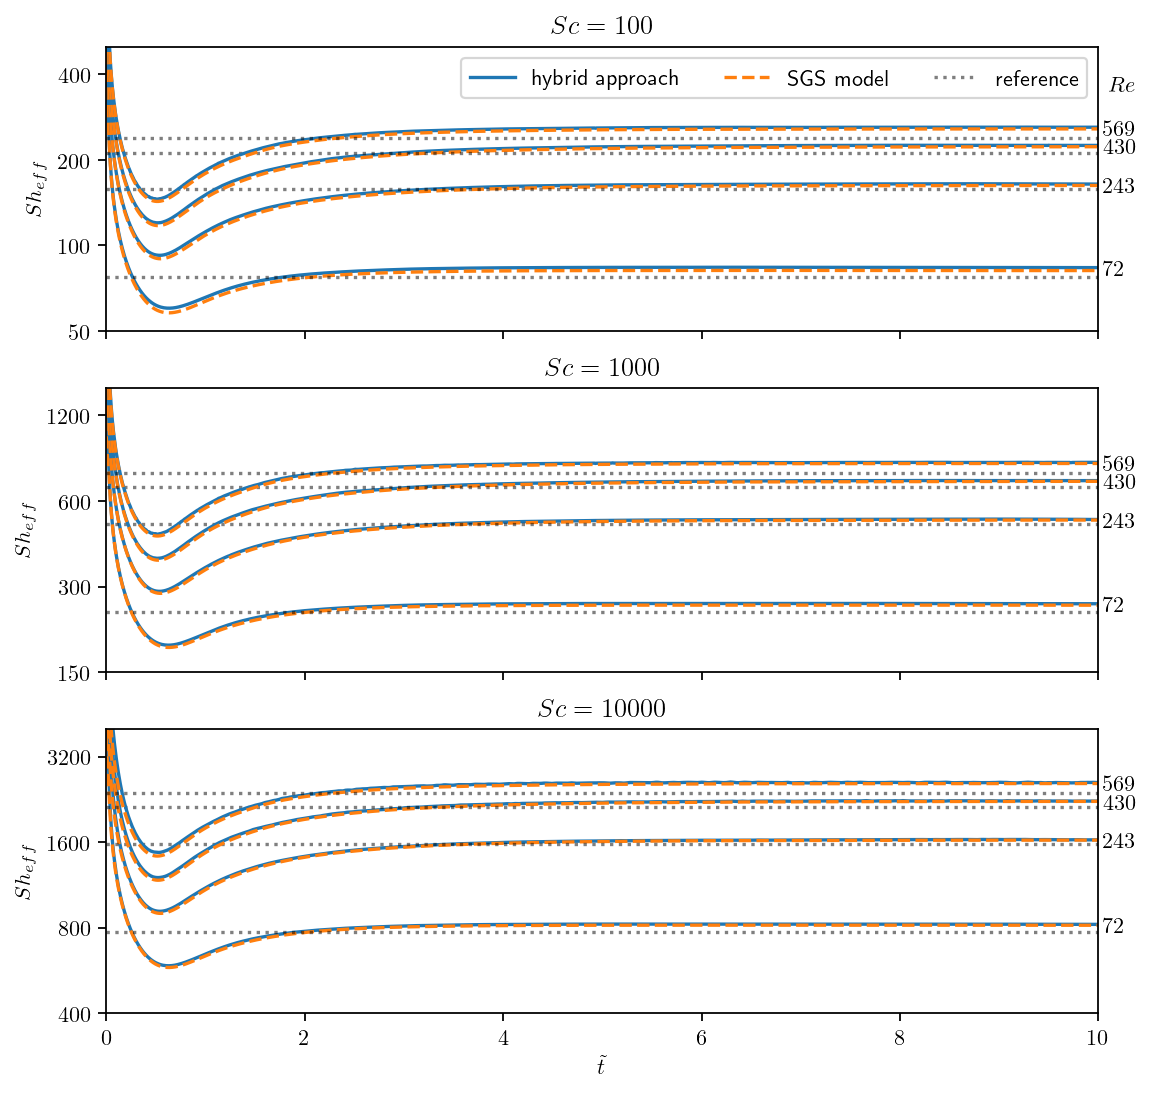

In [16]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

time_sgs = np.linspace(0.0, 10.0, 1e5)
l_bounds = [50, 150, 400]
u_bounds = [500, 1500, 4000]
ticks = [
    [50, 100, 200, 400],
    [150, 300, 600, 1200],
    [400, 800, 1600, 3200]
]

for i, (sc, sc_num) in enumerate(zip(["s1", "s2", "s3"], [100, 1000, 10000])):
    for j, case in enumerate(cases):
        # hybrid approach
        data = sh_glob_hybrid[data_path_hybrid + case + "_ref_1/globalSh_" + sc + ".csv"]
        sh_eff = data.Sh_eff
        # sgs model
        data_sgs = sh_glob_sgs["{:s}_{:d}".format(case, sc_num)]
        # correlation
        sh_ref = sh_lochiel(reynolds[j], schmidt[i]) * area_eq / data.area.values[-1]
        print("final steady state, Re={:3.0f}, Sc={:3.0f}, Pe={:3.0f}".format(np.round(reynolds[j]), np.round(schmidt[i]), np.round(reynolds[j]*schmidt[i])))
        print("hybrid: {:3.0f}".format(np.round(sh_eff.values[-1])))
        print("SGS model: {:3.0f} ({:3.2f}%)".format(np.round(data_sgs.Sh.values[-1]), (data_sgs.Sh.values[-1] - sh_eff.values[-1]) / sh_eff.values[-1] * 100))
        print("Lochiel & Calderbank: {:3.0f} ({:3.2f}%)".format(np.round(sh_ref), (sh_ref - sh_eff.values[-1]) / sh_eff.values[-1] * 100))
        print("Final area ratio eff/eq: {:1.4f}".format(np.round(data.area.values[-1] / area_eq, 4)))
        print("-"*40)
        if i==0 and j==0:
            axarr[i].plot(data.time, sh_eff, color="C0", ls="-", label=r"hybrid approach")
            axarr[i].plot(data_sgs.time, data_sgs.Sh, color="C1", ls="--", label=r"SGS model")
            axarr[i].plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5, label="reference")
        else:
            axarr[i].plot(data.time, sh_eff, color="C0", ls="-")
            axarr[i].plot(data_sgs.time, data_sgs.Sh, color="C1", ls="--")
            axarr[i].plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5)
        axarr[i].text(10.05, 0.94*sh_eff.values[-1], r"${:3.0f}$".format(np.round(reynolds[j], 0)))
    axarr[i].set_ylabel(r"$Sh_{eff}$")
    axarr[i].set_yscale("log")
    axarr[i].set_xlim(0.0, 10.0)
    axarr[i].set_ylim(l_bounds[i], u_bounds[i])
    axarr[i].set_yticks(ticks[i], minor=False)
    axarr[i].set_yticks([], minor=True)
    axarr[i].yaxis.set_major_formatter(ticker.FormatStrFormatter(r"$%3.0f$"))
    axarr[i].set_title(r"$Sc={:4.0f}$".format(schmidt[i]))
    
axarr[0].text(10.1, 350, r"$Re$")
axarr[0].legend(ncol=3, loc=0)
axarr[-1].set_xlabel(r"$\tilde{t}$")
plt.savefig(output_path + "sh_glob_comparison.pdf", bbox_inches="tight")

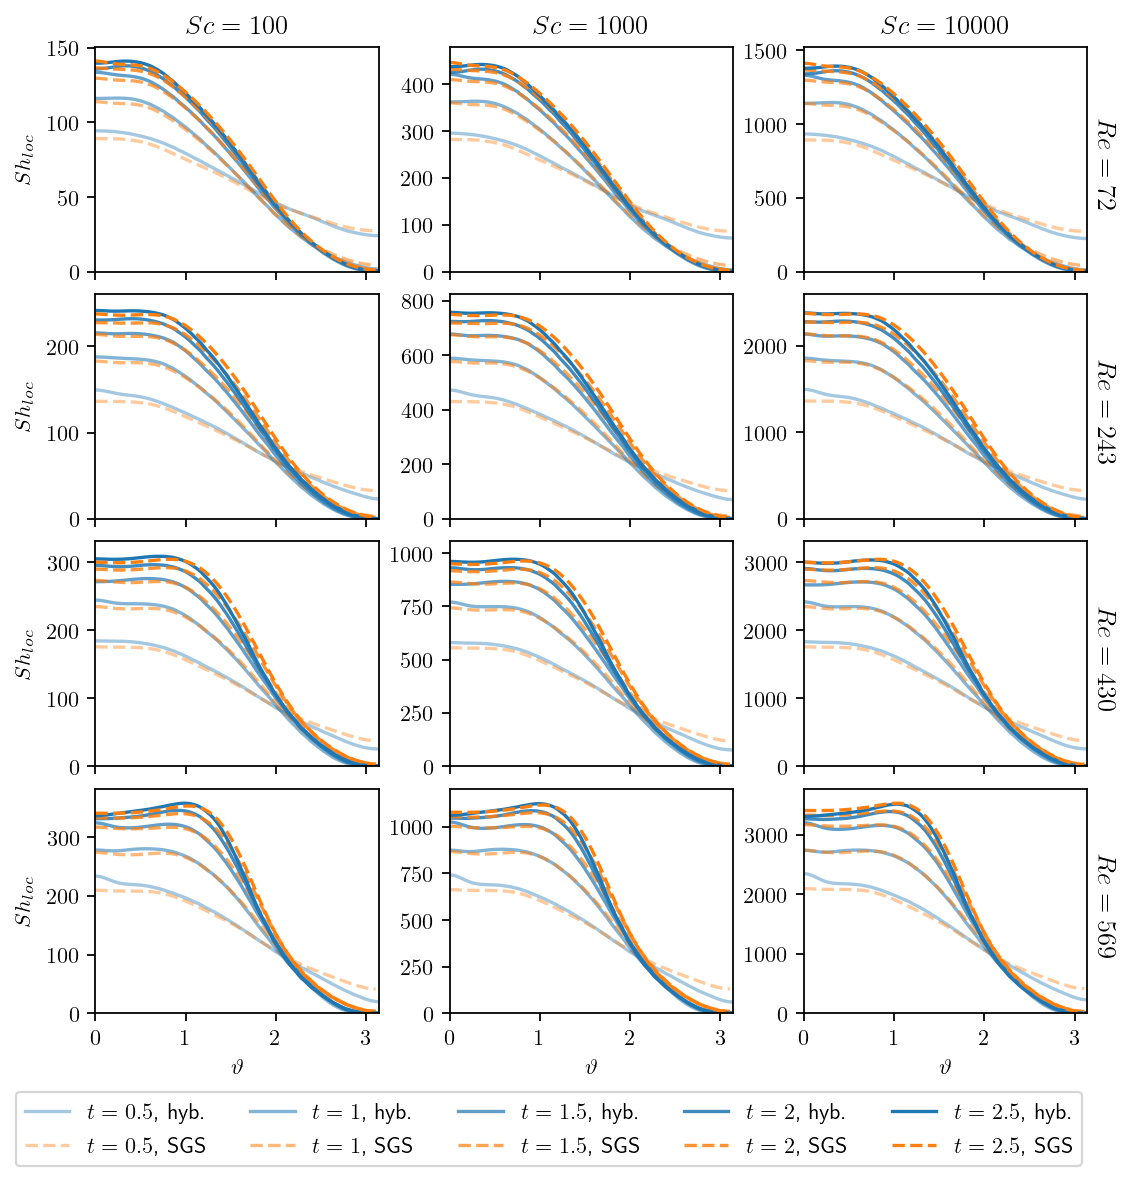

In [68]:
fig, axarr = plt.subplots(4, 3, figsize=(8, 8), sharex=True)

alpha = [0.4, 0.55, 0.7, 0.85, 1.0]
sigma = 4
theta_sgs = np.arange(0, 179, 2) * np.pi / 180

for i, case in enumerate(cases):
    for j, sc in enumerate(["s1", "s2", "s3"]):
        sgs = sh_local_sgs["{:s}_{:d}".format(case, schmidt[j])].values
        for t, time in enumerate(times[:5]):
            hybrid = sh_local_hybrid[data_path_hybrid + "{:s}_ref_1/{:s}/localSh_{:s}.csv".format(case, time, sc)]
            _, _, theta_1, sh_1 = compute_sh_sector_average(hybrid)
            if i == 3 and j==1:
                axarr[i, j].plot(theta_1, gaussian_filter1d(sh_1, sigma=sigma), color="C0", ls="-", alpha=alpha[t], label=r"$t={:s}$, hyb.".format(time))
                axarr[i, j].plot(theta_sgs, gaussian_filter1d(sgs[t], sigma=sigma), color="C1", ls="--", alpha=alpha[t], label=r"$t={:s}$, SGS".format(time))
            else:
                axarr[i, j].plot(theta_1, gaussian_filter1d(sh_1, sigma=sigma), color="C0", ls="-", alpha=alpha[t])
                axarr[i, j].plot(theta_sgs, gaussian_filter1d(sgs[t], sigma=sigma), color="C1", ls="--", alpha=alpha[t])
        
        axarr[i, j].set_ylim(0.0, np.max(sh_1)*1.05)
        if j==0:
            axarr[i, j].set_ylabel(r"$Sh_{loc}$")
        if j==2:
            axarr[i, j].text(3.2, np.max(sh_1)*0.5, r"$Re={:3.0f}$".format(np.round(reynolds[i])), rotation=-90, fontsize=12, va="center")
        if i==0:
            axarr[i, j].set_title(r"$Sc={:4.0f}$".format(schmidt[j]))
        if i==3:
            axarr[i, j].set_xlim(0.0, np.pi)
            axarr[i, j].set_xlabel(r"$\vartheta$")
            
box = axarr[3, 1].get_position()
axarr[3, 1].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

axarr[3, 1].legend(loc='upper center', bbox_to_anchor=(0.35, -0.3), ncol=5)

plt.subplots_adjust(hspace=0.1, wspace=0.25)
plt.savefig(output_path + "sh_local_comparison.pdf", bbox_inches="tight")

In [71]:
theta_sgs = np.arange(0, 179, 2) * np.pi / 180

for i, case in enumerate(cases):
    for j, sc in enumerate(["s1", "s2", "s3"]):
        sgs = sh_local_sgs["{:s}_{:d}".format(case, schmidt[j])].values
        print("Re={:2.4f}, Sc={:4d}".format(reynolds[i], schmidt[j]))
        print("-"*20)
        for t, time in enumerate(times[:5]):
            hybrid = sh_local_hybrid[data_path_hybrid + "{:s}_ref_1/{:s}/localSh_{:s}.csv".format(case, time, sc)]
            rad, x, theta, sh = compute_sh_sector_average(hybrid)
            sh_hybrid_sum = 0.0
            sh_sgs_sum = 0.0
            area_sum = 0.0
            sh_ref = np.dot(hybrid.area.values, hybrid.sh.values) / np.sum(hybrid.area.values)
            for sec in range(len(theta)):
                sh_hybrid_sum += sh[sec] * x[sec] * rad[sec] * 2.0*np.pi/180.0
                sh_sgs_sum += sgs[t][sec] * x[sec] * rad[sec] * 2.0*np.pi/180.0
                area_sum += x[sec] * rad[sec] * 2.0*np.pi/180.0
            print("t={:5s} hybrid/SGS org.: {:2.4f}, hybrid sec.: {:2.4f}, SGS sec.: {:2.4f}".format(time, sh_ref, sh_hybrid_sum / area_sum, sh_sgs_sum / area_sum))
        print("-"*20)

Re=71.9879, Sc= 100
--------------------
t=0.5   hybrid/SGS org.: 61.6104, hybrid sec.: 61.6154, SGS sec.: 60.1959
t=1     hybrid/SGS org.: 65.7346, hybrid sec.: 65.7411, SGS sec.: 65.8955
t=1.5   hybrid/SGS org.: 74.5573, hybrid sec.: 74.5672, SGS sec.: 75.4457
t=2     hybrid/SGS org.: 78.9838, hybrid sec.: 78.9994, SGS sec.: 80.6018
t=2.5   hybrid/SGS org.: 81.1761, hybrid sec.: 81.1972, SGS sec.: 83.2283
--------------------
Re=71.9879, Sc=1000
--------------------
t=0.5   hybrid/SGS org.: 190.9452, hybrid sec.: 190.9783, SGS sec.: 190.3434
t=1     hybrid/SGS org.: 205.0302, hybrid sec.: 205.0645, SGS sec.: 208.2738
t=1.5   hybrid/SGS org.: 232.8440, hybrid sec.: 232.8660, SGS sec.: 238.4159
t=2     hybrid/SGS org.: 246.7280, hybrid sec.: 246.7746, SGS sec.: 254.7227
t=2.5   hybrid/SGS org.: 253.6407, hybrid sec.: 253.7186, SGS sec.: 263.0317
--------------------
Re=71.9879, Sc=10000
--------------------
t=0.5   hybrid/SGS org.: 601.4746, hybrid sec.: 601.6437, SGS sec.: 601.9188
t=